In [23]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

### Reading the data
This is necessary for IBM WATSON

In [2]:
# The code was removed by Watson Studio for sharing.

,customer_id,country_name,age,customer_name,is_subscriber,subscriber_type,num_streams
0,1,united_states,21.0,Kasen Todd,True,aavail_premium,23.0
1,2,singapore,31.0,Ensley Garza,False,NaN,12.0
2,3,united_states,22.0,Lillian Carey,False,aavail_premium,22.0
3,4,united_states,21.0,Beau Christensen,True,aavail_basic,19.0
4,5,singapore,22.0,Ernesto Gibson,True,aavail_premium,23.0


### Checking for missing values

In [3]:
na_mask = df.isna()
print(na_mask.sum())
print("Number of rows with more than 2 missing values: {}".format((na_mask.sum(axis=1)>=2).sum()))

customer_id         0
country_name        0
age                 0
customer_name       0
is_subscriber       0
subscriber_type    72
num_streams        46
dtype: int64
Number of rows with more than 2 missing values: 1


### Making a copy without misssing values to be able to analyze features relations

In [4]:
df_1 = (df.drop(index = na_mask[na_mask.sum(axis=1) >= 1].index
                ,columns = ["customer_name"]))
df_1["is_subscriber"] = df_1["is_subscriber"].astype(int)
df_1.head()

,customer_id,country_name,age,is_subscriber,subscriber_type,num_streams
0,1,united_states,21.0,1,aavail_premium,23.0
2,3,united_states,22.0,0,aavail_premium,22.0
3,4,united_states,21.0,1,aavail_basic,19.0
4,5,singapore,22.0,1,aavail_premium,23.0
6,7,singapore,49.0,0,aavail_basic,18.0


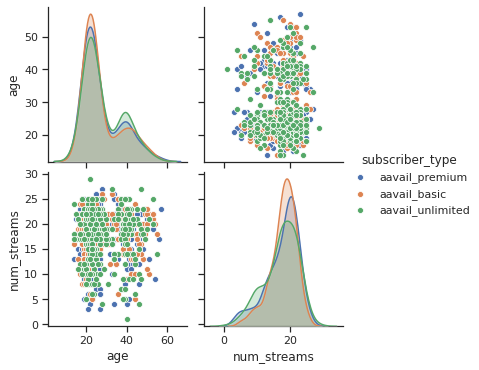

In [5]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(df_1,vars=["age","num_streams"],hue = "subscriber_type")

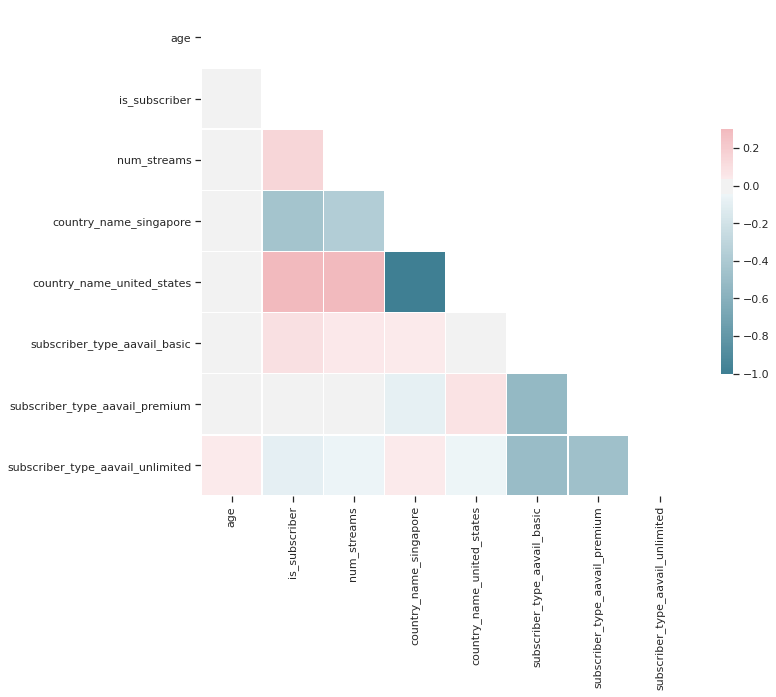

In [6]:
df_3 = pd.get_dummies(df_1)
corr = df_3[df_3.columns[1:]].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colorma
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Some conclusions
- In singapore there are less subscribers and num_streams (negative correlation)
- num_streams has a positive correlation with is_subscriber
- Age doesn't matter

### Decisions:
- Fill missing values on num_streams with the num_streams mean of the category (country,is_subscriber,subscriber_type)
- Fill missing values on subscriber_type comparing the num_streams value with the num_streams mean of each subscriber_type according to (country,is_subscriber)
- Delete the only row that has missing values on both columns

In [7]:
# drop row with 2 missing values
df_new = df.drop(na_mask[(na_mask.sum(axis=1)>=2)].index)

In [8]:
#mean of num_streams by categories
df_2 = pd.pivot_table(df_new,index=["country_name","is_subscriber","subscriber_type"],values = ["num_streams"],aggfunc="mean")
df_2

num_streams
country_name  is_subscriber subscriber_type              
singapore     False         aavail_basic        17.410256
                            aavail_premium      13.829787
                            aavail_unlimited    14.132353
              True          aavail_basic        16.400000
                            aavail_premium      14.652174
                            aavail_unlimited    14.238095
united_states False         aavail_basic        19.677419
                            aavail_premium      20.435897
                            aavail_unlimited    18.444444
              True          aavail_basic        18.565217
                            aavail_premium      18.701087
                            aavail_unlimited    19.075000

#### Fill missing values on num_streams

In [9]:
df_new_temp = df_new.join(df_2,on =["country_name","is_subscriber","subscriber_type"], rsuffix='_mean')
df_new_temp["num_streams"].fillna(value = df_new_temp["num_streams_mean"],inplace=True)
df_new_temp

,customer_id,country_name,age,customer_name,is_subscriber,subscriber_type,num_streams,num_streams_mean
0,1,united_states,21.0,Kasen Todd,True,aavail_premium,23.0,18.701087
1,2,singapore,31.0,Ensley Garza,False,NaN,12.0,NaN
2,3,united_states,22.0,Lillian Carey,False,aavail_premium,22.0,20.435897
3,4,united_states,21.0,Beau Christensen,True,aavail_basic,19.0,18.565217
4,5,singapore,22.0,Ernesto Gibson,True,aavail_premium,23.0,14.652174
...,...,...,...,...,...,...,...,...
995,996,singapore,55.0,Peyton Enriquez,False,aavail_unlimited,14.0,14.132353
996,997,united_states,23.0,Amina Manning,True,aavail_basic,24.0,18.565217
997,998,united_states,25.0,Brooks Ventura,True,aavail_unlimited,17.0,19.075000
998,999,united_states,40.0,Nayeli Mathis,True,aavail_unlimited,16.0,19.075000


In [10]:
#mean of num_streams by subscriber_type, considering (country,is_subscriber)
df_x = pd.pivot_table(df_new,index=["country_name","is_subscriber"],values ="num_streams",
                      columns=pd.Grouper(key="subscriber_type"),aggfunc="mean")
df_x

subscriber_type              aavail_basic  aavail_premium  aavail_unlimited
country_name  is_subscriber                                                
singapore     False             17.410256       13.829787         14.132353
              True              16.400000       14.652174         14.238095
united_states False             19.677419       20.435897         18.444444
              True              18.565217       18.701087         19.075000

#### Fill missing values on subscriber_type
Using the category that has the closest num_streams mean to the real value of num_streams, considering subscriber_type and country

In [11]:
df_new_temp_2 = (df_new_temp.join(df_x,on =["country_name","is_subscriber"], rsuffix='_mean_streams'))
#df_new_temp_2["num_streams"].fillna(value = df_new_temp["num_streams_mean"],inplace=True)
arr = abs(np.array([df_new_temp_2["num_streams"]-df_new_temp_2["aavail_basic"],
         df_new_temp_2["num_streams"]-df_new_temp_2["aavail_premium"],
        df_new_temp_2["num_streams"]-df_new_temp_2["aavail_unlimited"]]).T)

columns = np.array(["aavail_basic","aavail_premium","aavail_unlimited"])
closest = np.argmin(arr,axis=1)
df_new_temp_2["subscriber_type"].fillna(value = pd.Series(columns[closest]),inplace = True)
df_final = (df_new_temp_2.copy()
           .drop(columns= ["num_streams_mean","aavail_basic","aavail_premium","aavail_unlimited"]))
df_final

,customer_id,country_name,age,customer_name,is_subscriber,subscriber_type,num_streams
0,1,united_states,21.0,Kasen Todd,True,aavail_premium,23.0
1,2,singapore,31.0,Ensley Garza,False,aavail_premium,12.0
2,3,united_states,22.0,Lillian Carey,False,aavail_premium,22.0
3,4,united_states,21.0,Beau Christensen,True,aavail_basic,19.0
4,5,singapore,22.0,Ernesto Gibson,True,aavail_premium,23.0
...,...,...,...,...,...,...,...
995,996,singapore,55.0,Peyton Enriquez,False,aavail_unlimited,14.0
996,997,united_states,23.0,Amina Manning,True,aavail_basic,24.0
997,998,united_states,25.0,Brooks Ventura,True,aavail_unlimited,17.0
998,999,united_states,40.0,Nayeli Mathis,True,aavail_unlimited,16.0


#### Checking for missing values

In [12]:
na_mask = df_final.isna()
print(na_mask.sum())

customer_id        0
country_name       0
age                0
customer_name      0
is_subscriber      0
subscriber_type    0
num_streams        0
dtype: int64


### Important Visualizations
- Percentage of non_subscribers per country
- num_streams statistics on new dataset vs old dataset
- Percentage for each subscriber_type on new dataset vs old dataset

In [13]:
print(df["num_streams"].describe())
print(df_final["num_streams"].describe())

count    954.000000
mean      17.780922
std        4.752115
min        1.000000
25%       15.000000
50%       19.000000
75%       21.000000
max       29.000000
Name: num_streams, dtype: float64
count    999.000000
mean      17.749453
std        4.664484
min        1.000000
25%       15.000000
50%       18.701087
75%       21.000000
max       29.000000
Name: num_streams, dtype: float64


#### There has not been a significant change on num_streams statistics

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f57480ee710>,
      dtype=object)

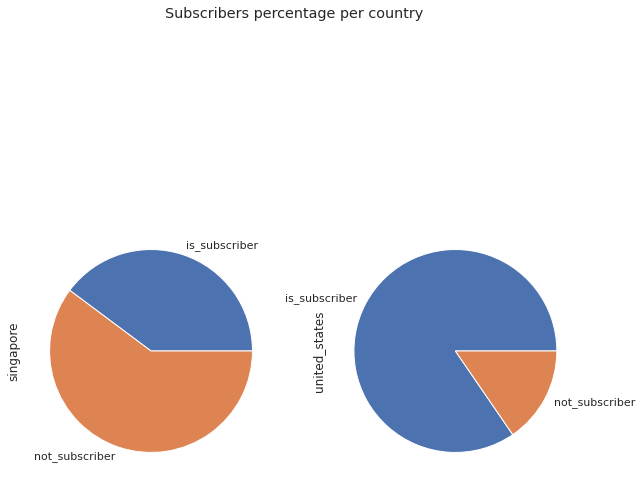

In [14]:
df_final["is_subscriber"] = df_final["is_subscriber"].astype(int)
df_frequency =pd.pivot_table(df_final,index="country_name",values = "is_subscriber",aggfunc="mean")
df_frequency["not_subscriber"] = 1-df_frequency["is_subscriber"]
df_frequency.T.plot.pie(figsize=(10,10),title = "Subscribers percentage per country",legend = False,subplots=True)

#### In singapore there is a significant bigger portion of non subscribers

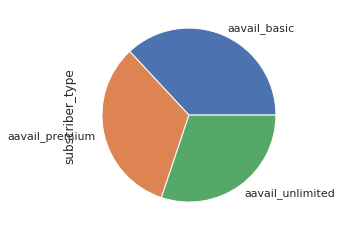

In [15]:
df_frequency_2 = df_final["subscriber_type"]
df_frequency_2 = df_frequency_2.value_counts()
df_frequency_2.plot.pie()
#df_frequency_2.T.plot.pie(figsize=(10,10),title = "Subscribers percentage per country",legend = False,subplots=True)

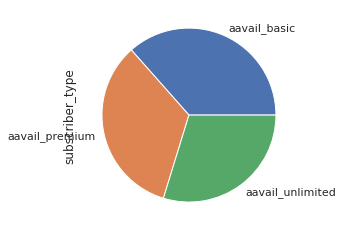

In [16]:
df_frequency_2 = df["subscriber_type"]
df_frequency_2 = df_frequency_2.value_counts()
df_frequency_2.plot.pie()

#### There has not been significant change on subscriber_type distribution.